In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:

# Generate training data
np.random.seed(42)
num_samples = 1000
x_train = np.random.uniform(low=0, high=1, size=(num_samples, 1))
t_train = np.random.uniform(low=0, high=1, size=(num_samples, 1))
u_exact = np.sin(np.pi * x_train) * np.exp(-np.pi**2 * t_train)

# Convert to TensorFlow tensors
x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
t_train_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)
u_exact_tf = tf.convert_to_tensor(u_exact, dtype=tf.float32)

# Combine x and t for training input
input_train = tf.concat([x_train_tf, t_train_tf], axis=1)

# Generate test data for prediction
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
t_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Convert to TensorFlow tensors
x_test_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)
t_test_tf = tf.convert_to_tensor(t_test, dtype=tf.float32)
input_test = tf.concat([x_test_tf, t_test_tf], axis=1)
u_exact_test = np.sin(np.pi * x_test) * np.exp(-np.pi**2 * t_test)
u_exact_test_tf = tf.convert_to_tensor(u_exact_test, dtype=tf.float32)

In [49]:
# Define the neural network model
model = Sequential([
    # Dense(units=2, activation='tanh'),
    Dense(units=50, activation='tanh'),
    Dense(units=50, activation='tanh'),
    Dense(units=25, activation='tanh'),
    Dense(units=15, activation='tanh'),
    Dense(units=1, activation='tanh')
])

In [50]:
initial_alpha = tf.Variable(0.00001, dtype=tf.float32)

# Define the loss function
def loss(model, x, t, alpha):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        u_pred = model(tf.concat((x, t), axis=1))
        du_x = tape.gradient(u_pred, x)
        du_xx = tape.gradient(du_x, x)
        du_dt = tape.gradient(u_pred, t)
        del tape

    physics_residual = du_dt - alpha * du_xx
    physics_loss = tf.reduce_mean(tf.square(physics_residual))
    data_loss = tf.reduce_mean(tf.square(u_pred - u_exact_tf))
    total_loss = physics_loss + data_loss
    
    return total_loss, physics_loss, data_loss

In [61]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

# Training loop
num_epochs = 2000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        total_loss, physics_loss_value, data_loss_value = loss(model, x_train_tf, t_train_tf, initial_alpha)
        
    gradients = tape.gradient(total_loss, model.trainable_variables + [initial_alpha])
    optimizer.apply_gradients(zip(gradients, model.trainable_variables + [initial_alpha]))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Total Loss: {total_loss.numpy()}, Physics Loss: {physics_loss_value.numpy()}, Data Loss: {data_loss_value.numpy()}")


Epoch 0/2000, Total Loss: 0.0008758752373978496, Physics Loss: 0.00037232483737170696, Data Loss: 0.0005035504000261426
Epoch 100/2000, Total Loss: 0.005856472533196211, Physics Loss: 0.0005663311458192766, Data Loss: 0.005290141329169273
Epoch 200/2000, Total Loss: 0.0032830953132361174, Physics Loss: 0.00045930809574201703, Data Loss: 0.0028237872757017612
Epoch 300/2000, Total Loss: 0.002544006332755089, Physics Loss: 0.0006341901607811451, Data Loss: 0.0019098160555586219
Epoch 400/2000, Total Loss: 0.002690800465643406, Physics Loss: 0.0011025897692888975, Data Loss: 0.0015882108127698302
Epoch 500/2000, Total Loss: 0.0015700109070166945, Physics Loss: 0.0003282107936684042, Data Loss: 0.0012418001424521208
Epoch 600/2000, Total Loss: 0.0012628799304366112, Physics Loss: 0.00027303252136334777, Data Loss: 0.0009898473508656025
Epoch 700/2000, Total Loss: 0.0010623964481055737, Physics Loss: 0.00021514587569981813, Data Loss: 0.0008472506306134164
Epoch 800/2000, Total Loss: 0.0010

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [63]:
u_pred = model(tf.concat([x_train_tf, t_train_tf], axis=1))

In [64]:
# Prediction on test data
u_pred_test = model(tf.concat([x_test_tf, t_test_tf], axis=1))

# Calculate Mean Squared Error on test data
mse_test = mean_squared_error(u_exact_test_tf, u_pred_test)
print(f"Mean Squared Error on Test Data: {mse_test}")

# Calculate Mean Absolute Error on test data
mae_test = mean_absolute_error(u_exact_test_tf, u_pred_test)
print(f"Mean Absolute Error on Test Data: {mae_test}")

Mean Squared Error on Test Data: 0.00011772578727686778
Mean Absolute Error on Test Data: 0.005119078792631626


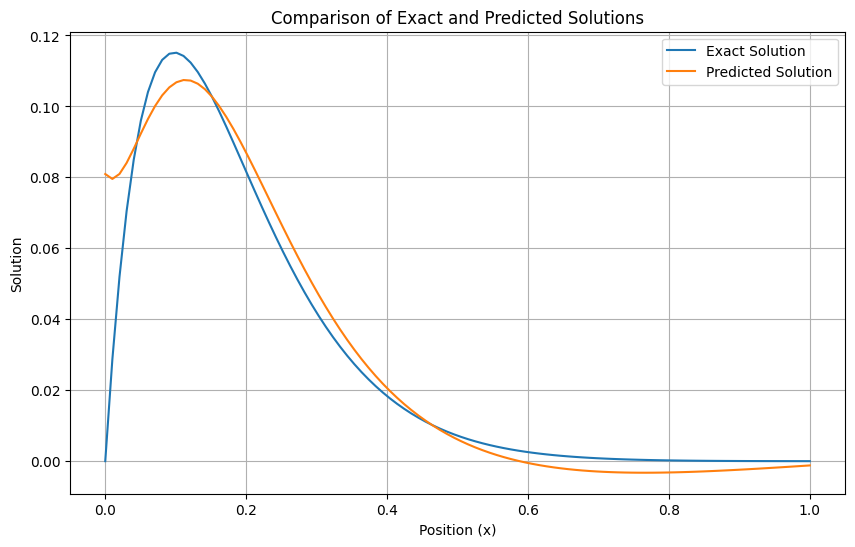

In [65]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_test, u_exact_test, label='Exact Solution')
plt.plot(x_test, u_pred_test, label='Predicted Solution')
plt.xlabel('Position (x)')
plt.ylabel('Solution')
plt.title('Comparison of Exact and Predicted Solutions')
plt.legend()
plt.grid(True)
plt.show()